In [69]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from google.colab import files

# Load the Food-101 dataset (train only)
dataset, info = tfds.load("food101", split="train", as_supervised=True, with_info=True)

# Get the class names
class_names = info.features['label'].names[:10]  # Select the first 10 classes
num_classes = len(class_names)

# Filter the dataset to keep only the first 10 classes
def filter_classes(image, label):
    return tf.reduce_any([label == i for i in range(10)])

filtered_dataset = dataset.filter(filter_classes)

# Preprocessing function without data augmentation
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0  # Normalization [0,1]
    return image, label

# Apply preprocessing
filtered_dataset = filtered_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Calculate dataset size and split indices
dataset_size = sum(1 for _ in filtered_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Split the dataset into training and validation sets
train_ds = filtered_dataset.take(train_size)
val_ds = filtered_dataset.skip(train_size)

# Batch and prefetch the datasets
train_ds = train_ds.batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

In [70]:
# Load the pre-trained ResNet50 model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base layers

# Add custom layers for classification, with reduced pooling
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, (5, 5), strides=1, padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(32, (5, 5), strides=1, padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax', kernel_initializer='he_normal')
])


In [71]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [72]:
# Display the model structure
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_116 (Conv2D)                  │ (None, 7, 7, 32)            │       1,638,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_117 (Conv2D)                  │ (None, 7, 7, 32)            │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_118 (Conv2D)                  │ (None, 3, 3, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_119 (Conv2D)                  │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_120 (Conv2D)                  │ (None, 1, 1, 128)           │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_121 (Conv2D)                  │ (None, 1, 1, 128)           │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_122 (Conv2D)                  │ (None, 1, 1, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_123 (Conv2D)                  │ (None, 1, 1, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_29          │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_75 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,427,722 (100.81 MB)

 Trainable params: 2,840,010 (10.83 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [73]:
# Train the model
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[
    tf.keras.callbacks.ModelCheckpoint(filepath='resnet_v2_model.weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
])

Epoch 1/100
     94/Unknown 42s 234ms/step - accuracy: 0.1011 - loss: 2.3072

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 2.26572, saving model to resnet_v2_model.weights.h5
94/94 ━━━━━━━━━━━━━━━━━━━━ 65s 484ms/step - accuracy: 0.1011 - loss: 2.3071 - val_accuracy: 0.1500 - val_loss: 2.2657 - learning_rate: 0.0010
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.1558 - loss: 2.2593
Epoch 2: val_loss improved from 2.26572 to 2.23203, saving model to resnet_v2_model.weights.h5
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 282ms/step - accuracy: 0.1557 - loss: 2.2592 - val_accuracy: 0.1300 - val_loss: 2.2320 - learning_rate: 0.0010
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.1636 - loss: 2.2136
Epoch 3: val_loss improved from 2.23203 to 2.20709, saving model to resnet_v2_model.weights.h5
94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 283ms/step - accuracy: 0.1637 - loss: 2.2135 - val_accuracy: 0.1467 - val_loss: 2.2071 - learning_rate: 0.0010
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.1595 - loss: 2.2011
Epoch 4: val_loss did not impro

In [74]:
# Download the saved model
files.download('resnet_v2_model.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
# Evaluate the model on the validation dataset
test_loss, test_acc = model.evaluate(val_ds)
print(f'\nValidation Accuracy: {test_acc * 100:.2f}%')
print(f'\nValidation Loss: {test_loss:.4f}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.1479 - loss: 2.1429

Validation Accuracy: 15.13%

Validation Loss: 2.1604


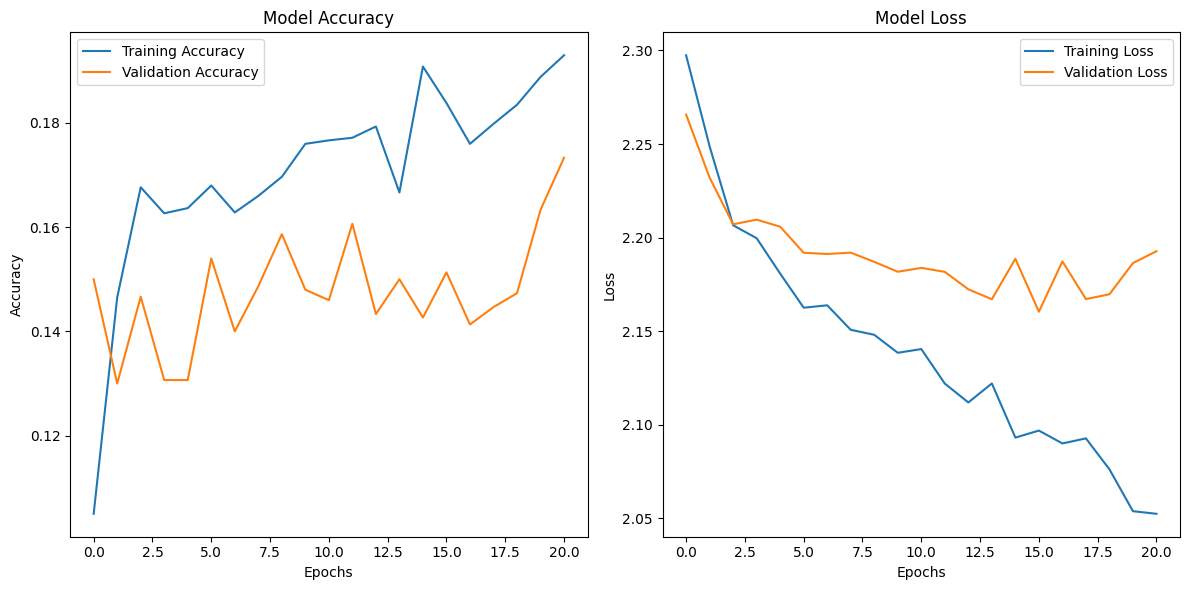

In [76]:
import matplotlib.pyplot as plt
# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [77]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Classification report
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 302ms/step
Classification Report:
                   precision    recall  f1-score   support

        apple_pie     0.0000    0.0000    0.0000       152
   baby_back_ribs     0.1207    0.4148    0.1870       135
          baklava     0.1611    0.3478    0.2202       138
   beef_carpaccio     0.2030    0.2645    0.2297       155
     beef_tartare     0.0000    0.0000    0.0000       157
       beet_salad     1.0000    0.0139    0.0274       144
         beignets     0.0000    0.0000    0.0000       170
         bibimbap     0.0000    0.0000    0.0000       166
    bread_pudding     0.1371    0.2361    0.1735       144
breakfast_burrito     0.1608    0.3309    0.2165       139

         accuracy                         0.1513      1500
        macro avg     0.1783    0.1608    0.1054      1500
     weighted avg     0.1707    0.1513    0.1002      1500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


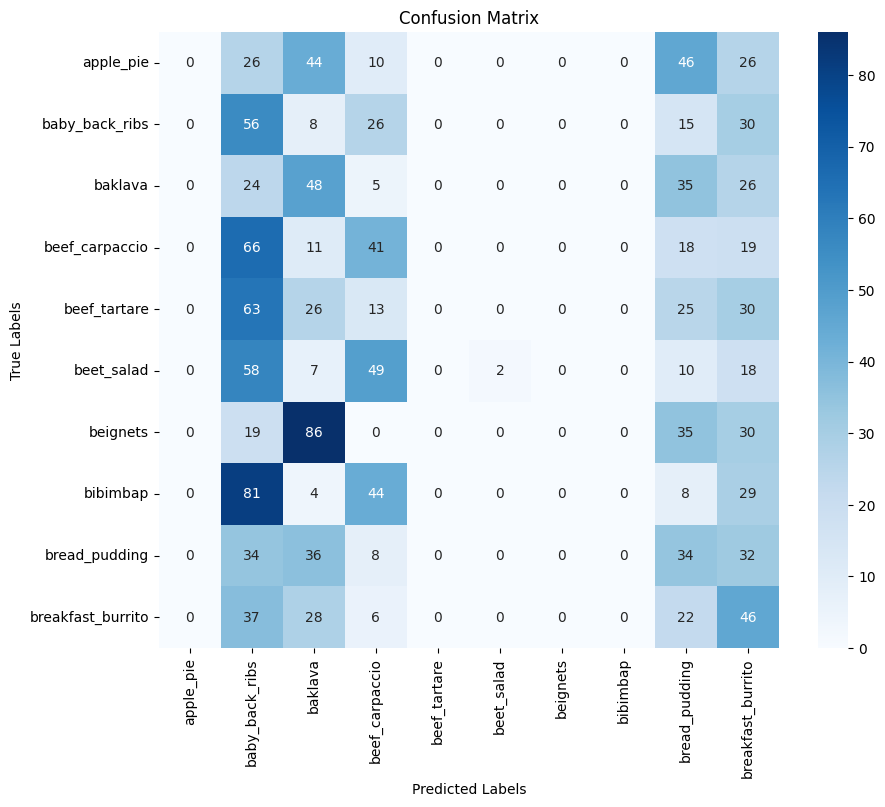

In [78]:
#confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()